In [11]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [14]:
!pip install tensorflow
!pip install opencv-python
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import pandas as pd
import shutil

# Base directory containing the train, valid, and test folders
base_path = r"E:\Research\dev\Copra_Grading_Research\copra_mold_data"

# List of dataset folders
dataset_folders = ['train', 'valid', 'test']

def organize_images_for_all_folders(base_path, dataset_folders):
    for folder in dataset_folders:
        # Construct the path to the dataset folder
        folder_path = os.path.join(base_path, folder)
        
        # Construct the path to the CSV file
        csv_file = os.path.join(folder_path, "_annotations.csv")
        
        # Create mold and no_mold directories
        mold_dir = os.path.join(folder_path, "mold")
        no_mold_dir = os.path.join(folder_path, "no-mold")
        os.makedirs(mold_dir, exist_ok=True)
        os.makedirs(no_mold_dir, exist_ok=True)
        
        # Read the CSV file
        try:
            data = pd.read_csv(csv_file)
        except FileNotFoundError:
            print(f"CSV file not found in {folder_path}")
            continue
        except pd.errors.EmptyDataError:
            print(f"CSV file is empty in {folder_path}")
            continue
        
        # Ensure the CSV contains required columns
        if 'filename' not in data.columns or 'class' not in data.columns:
            print(f"CSV in {folder_path} does not have required columns: 'filename' and 'class'")
            print(f"Available columns: {data.columns}")
            continue
        
        # Move images into the correct subfolders
        for _, row in data.iterrows():
            image_path = os.path.join(folder_path, row['filename'])
            if not os.path.exists(image_path):
                print(f"Image {row['filename']} not found in {folder_path}")
                continue
            
            if row['class'] == "mold":
                shutil.move(image_path, os.path.join(mold_dir, row['filename']))
            elif row['class'] == "no-mold":
                shutil.move(image_path, os.path.join(no_mold_dir, row['filename']))
            else:
                print(f"Invalid class {row['class']} in CSV: {csv_file}")

# Organize images for train, valid, and test folders
organize_images_for_all_folders(base_path, dataset_folders)


Image mold_image_0018_png.rf.1b2da96ecdde6c7ee506ba427ad94b30.jpg not found in E:\Research\dev\Copra_Grading_Research\copra_mold_data\train
Image mold_image_0018_png.rf.1b2da96ecdde6c7ee506ba427ad94b30.jpg not found in E:\Research\dev\Copra_Grading_Research\copra_mold_data\train
Image mold_image_0018_png.rf.1b2da96ecdde6c7ee506ba427ad94b30.jpg not found in E:\Research\dev\Copra_Grading_Research\copra_mold_data\train
Image B68B8B9634896_jpg.rf.082224b2074af5b72fa66afff765baab.jpg not found in E:\Research\dev\Copra_Grading_Research\copra_mold_data\train
Image mold_image_0000_png.rf.086c392159d4898a02ae99465876cdd7.jpg not found in E:\Research\dev\Copra_Grading_Research\copra_mold_data\train
Image mold_image_0000_png.rf.086c392159d4898a02ae99465876cdd7.jpg not found in E:\Research\dev\Copra_Grading_Research\copra_mold_data\train
Image mold_image_0000_png.rf.086c392159d4898a02ae99465876cdd7.jpg not found in E:\Research\dev\Copra_Grading_Research\copra_mold_data\train
Image mold_image_0010_

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [35]:
# Base directory
base_path = r"E:\Research\dev\Copra_Grading_Research\copra_mold_data"

# Directories for train, valid, test
train_dir = os.path.join(base_path, "train")
valid_dir = os.path.join(base_path, "valid")
test_dir = os.path.join(base_path, "test")

# Hyperparameters
IMG_SIZE = (150, 150)  # Image dimensions
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.007


In [39]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Data loaders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Keep order for evaluation
)


Found 123 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


In [41]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [43]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator
)

C:\Users\ASUS VIVOBOOK\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4999 - loss: 17.0109 - val_accuracy: 0.4000 - val_loss: 21.2122
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4728 - loss: 11.4458 - val_accuracy: 0.6000 - val_loss: 0.9822
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5550 - loss: 0.9780 - val_accuracy: 0.6000 - val_loss: 0.6763
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5552 - loss: 0.6952 - val_accuracy: 0.6000 - val_loss: 0.6740
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5509 - loss: 0.6968 - val_accuracy: 0.6000 - val_loss: 0.6816
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5608 - loss: 0.6921 - val_accuracy: 0.6000 - val_loss: 0.6785
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5331 - loss: 0.6920 - val_accuracy: 0.6000 - val_loss: 0.6781
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5561 - loss: 0.6909 - val_accuracy: 0.6000 - val_loss: 0.6777
Epoch 9/50
2/

In [45]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification Report and Confusion Matrix
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype("int32").flatten()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['No Mold', 'Mold']))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8571 - loss: 0.4189
Test Accuracy: 85.71%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Classification Report:
              precision    recall  f1-score   support

     No Mold       0.89      0.89      0.89         9
        Mold       0.80      0.80      0.80         5

    accuracy                           0.86        14
   macro avg       0.84      0.84      0.84        14
weighted avg       0.86      0.86      0.86        14

Confusion Matrix:
[[8 1]
 [1 4]]


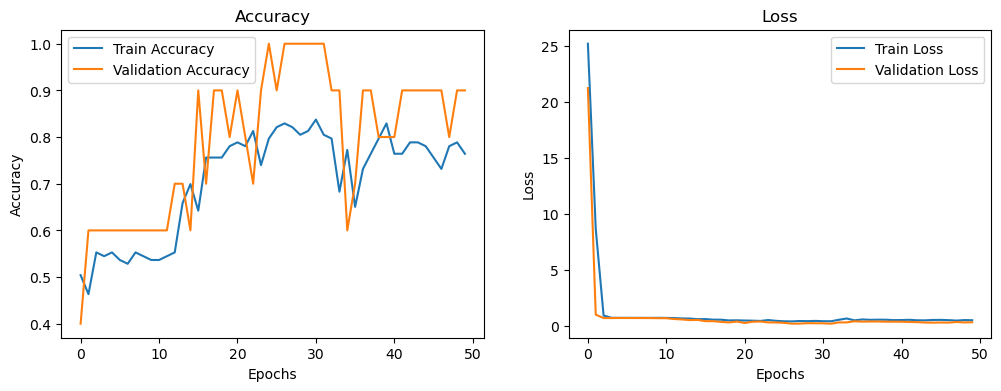

In [47]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [67]:
model.save("copra_mold_classifier.keras")

In [69]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("copra_mold_classifier.keras")

In [73]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Path to the new image
new_image_path = r"E:\Research\dev\Copra_Grading_Research\copra_mold_data\m2.jpg"  # Change to your test image path

# Load the image and preprocess it
IMG_SIZE = (150, 150)  # Ensure this matches the size used during training
image = load_img(new_image_path, target_size=IMG_SIZE)  # Load and resize the image
image_array = img_to_array(image)  # Convert to a NumPy array
image_array = image_array / 255.0  # Normalize pixel values
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

In [77]:
# Predict
prediction = model.predict(image_array)

# Interpret the result
if prediction[0][0] > 0.5:
    print("The image is classified as: Mold")
else:
    print("The image is classified as: No Mold")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
The image is classified as: No Mold


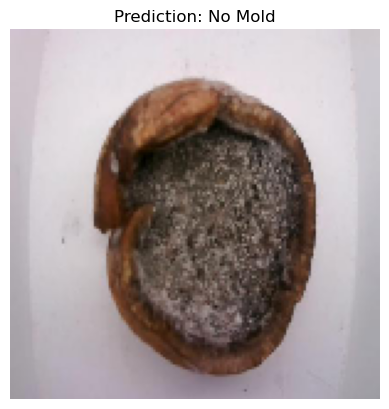

In [79]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(image)
plt.axis('off')
plt.title("Prediction: Mold" if prediction[0][0] > 0.5 else "Prediction: No Mold")
plt.show()
